# Image Cropping and Preprocessing

### The datasets namely Messidor-1, Messidor-2, Aptos, IDRiD, etc and many others don't have exactly same dimension images. Also the background areas in some images are greater in size than the retinal area. 
### So cropping of images is to be done for ensuring maximum retinal area along with changing images to similar dimensions and ensuring the condition "width = height".

In [29]:
import os
import cv2
import matplotlib.pyplot as plt
import shutil
import numpy as np
from PIL import Image

In [16]:
def crop_image_from_gray(img,tol=7):
    """
    This function takes an image as input along with 'tol' that is a threshold value.
    
    Here we need to mask the black areas in the images and so we have set 'tol' to 7. 
    'tol' can have any values in range 0 to 10 that coresspond to black regions.
    
    Here 'img>tol' will return an array of booleans of similar shape as img having true and false values 
    according to the condition.
    
    Here is we have gray scale image we will mask only the last one channel. 
    But in case of RGB/BGR image we have to mask all the color channels.
    """
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [30]:
def circle_crop(img):
    """
    This function will convert a rectangular/irregular image into a square/regular shaped image.
    
    It will resize both dimesions equal to the larger of width or height in the original image.
    
    Here we have interest only in the retina region and so to get the circular retinal region we 
    make a black image of same size as resized image and plot a white circle onto it to capture the retina
    in a circular region.
    
    Finally we perform 'bitwise_and' to get the retinal region in our image only from the circular part made above.
    
    Then we again perform cropping to remove the black areas.
    """
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

In [44]:
def clahe_image(img):
    """
    This function allows to apply Contrast Limited Adaptive Histogram Equalisation to our image.
    
    Initially an image is taken and its green channel is extracted because all the legions are 
    visible clearly on the green component of the image.
    Then we create a CLAHE with a clipLimit of 3. 
    As clipLimit decreases the image becomes normal, as clipLimit increases the image becomes more contrastive.
    '3' is an ideal value according to me.
    Finally we apply the created CLAHE onto the green image.
    
    """
    clahe = cv2.createCLAHE(clipLimit = 3)
    img_g = img[:,:,1]
    img_clahe = clahe.apply(img_g)
    
    return img_clahe

In [32]:
def crop_with_clahe(img):
    """
    This function performs 2 operations
    1.) Cropping of Image along with sizing the Image 
    2.) Applying CLAHE onto the resulting Image
    
    """
    circle_cropped = circle_crop(img)
    final_image = clahe_image(circle_cropped)
    return final_image

In [26]:
path = "TEST/"

In [27]:
images = os.listdir(path)

In [33]:
sample_image = images[7]

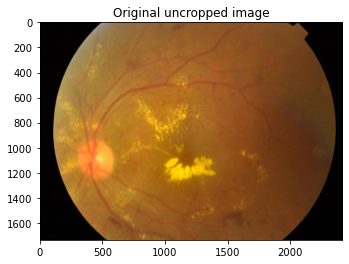

In [46]:
image_bgr = cv2.imread(path+sample_image)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.title("Original uncropped image")
plt.imshow(image_rgb)

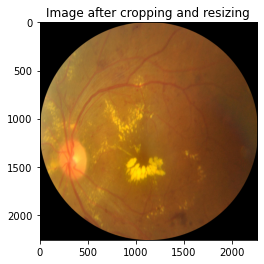

In [47]:
image_cropped = circle_crop(image_rgb)
plt.title("Image after cropping and resizing")
plt.imshow(image_cropped)

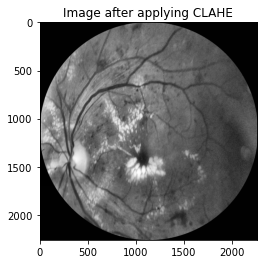

In [48]:
image_clahe = clahe_image(image_cropped)
plt.title("Image after applying CLAHE")
plt.imshow(image_clahe, cmap="gray")

In [42]:
for img in images:
    img_bgr = cv2.imread(path+img)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    img_final = crop_with_clahe(img_rgb)
    pil_image = Image.fromarray(img_final)
    pil_image.save("TEST_CLAHE/"+img)